In [1]:
pip install tensorflow-gpu

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pandas as pd
from matplotlib import gridspec
from scipy import stats, interpolate
import os
from tensorflow.keras import backend as K  

import tqdm

In [3]:
def load_data (path, name='dataset', train=None, test=None, signal=None, background=None, sample=None, seed=21, replace=True):
    """
    General script to load data, common to all run scripts.

    Arguments:
        path: The path to the HDF5 file, from which data should be loaded.
        name: Name of the dataset, as stored in the HDF5 file.
        ...

    Returns:
        Tuple of pandas.DataFrame containing the loaded; list of loaded features
        to be used for training; and list of features to be used for mass-
        decorrelation.

    Raises:
        IOError: If no HDF5 file exists at the specified `path`.
        KeyError: If the HDF5 does not contained a dataset named `name`.
        KeyError: If any of the necessary features are not present in the loaded
            dataset.
    """

    # Check(s)
    #assert False not in [train, test, signal, background]
    #if sample: assert 0 < sample and sample < 1.

    # Read data from HDF5 file
    data = pd.read_hdf(path)

    # Subsample signal by x10 for testing: 1E+07 -> 1E+06
    np.random.seed(7)
    try:
        msk_test  = data['train'] == 0
        msk_train = ~msk_test
        msk_bkg = data['signal'] == 0
        msk_sig = ~msk_bkg
        #idx_sig = np.where(msk_sig)[0]
        #idx_sig = np.random.choice(idx_sig, int(msk_sig.sum() * 0.1), replace=False)
        #msk_sig = np.zeros_like(msk_bkg).astype(bool)
        #msk_sig[idx_sig] = True
        #data = data[msk_train | (msk_test & (msk_sig | msk_bkg))]
    except:
        #log.warning("Some of the keys ['train', 'signal'] were not present in file {}".format(path))
        print("Some of the keys ['train', 'signal'] were not present in file {}".format(path))
        pass



    # Define feature collections to use
    features_input = ['Tau21pJ1', 'Tau21J2', 'Tau32J1', 'Tau32J2']
    features_decorrelation = ['m']

    # Split data
    if train:
        #log.info("load_data: Selecting only training data.")
        data = data[data['train']  == 1]
        pass

    if test:
        # log.info("load_data: Selecting only testing data.")
        data = data[data['train']  == 0]
        pass

    if signal:
        #log.info("load_data: Selecting only signal data.")
        data = data[data['signal'] == 1]
        pass

    if background:
        #log.info("load_data: Selecting only background data.")
        data = data[data['signal'] == 0]
        pass

    if sample:
        #log.info("load_data: Selecting a random fraction {:.2f} of data (replace = {}, seed = {}).".format(sample, replace, seed))
        data = data.sample(frac=sample, random_state=seed, replace=False)
        pass

    # Return
    return data, features_input, features_decorrelation


In [4]:
alpha = 0.1

def load_dataT21(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo"]]
    return dataset.to_numpy()

def load_dataT32(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau3jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jOne"] = dataset["tau3jOne"]/dataset["tau2jOne"]
    dataset["tau32jTwo"] = dataset["tau3jTwo"]/dataset["tau2jTwo"] 
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau32jOne", "tau32jTwo"]]
    return dataset.to_numpy()

def load_data_more(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2"]]
    
    #Masa ya al cuadrado
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    
    
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)

    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    
    #tau32
    dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau3jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jOne"] = dataset["tau3jOne"]/dataset["tau2jOne"]
    dataset["tau32jTwo"] = dataset["tau3jTwo"]/dataset["tau2jTwo"]   
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    dataset["pTjOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["pT2"]
    dataset["pTjTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["pT2"]    
    
    #eta
    dataset["E1"] = ((1000*dataset["pT1"])**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5/1000.
    dataset["E2"] = ((1000*dataset["pT2"])**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5/1000.
    dataset["y1"] = 0.5*np.log((dataset["E1"] + input_frame["pzj1"]/1000.)/(dataset["E1"] - input_frame["pzj1"]/1000.))
    dataset["y2"] = 0.5*np.log((dataset["E2"] + input_frame["pzj2"]/1000.)/(dataset["E2"] - input_frame["pzj2"]/1000.))
    dataset["Dy"] = dataset["y1"]-dataset["y2"]
    
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo", "tau32jOne", "tau32jTwo","pTjOne","pTjTwo","Dy"]]
    return dataset.to_numpy()

column_labelsT21 = [
    r"$m_{JJ}$",
    r"$m^{J_1}$",
    "$m^{J_2} - m^{J_1}$",
    r"$\tau_{2,1}^{J_1}$", 
    r"$\tau_{2,1}^{J_2}$",
]

column_labelsT32 = [
    r"$m_{JJ}$",
    r"$m^{J_1}$",
    "$m^{J_2} - m^{J_1}$",
    r"$\tau_{3,2}^{J_1}$", 
    r"$\tau_{3,2}^{J_2}$",
]

In [8]:

original_data=pd.read_hdf("/Users/bolit/All/Documentos/Tec/7_semestre/investigacion/CWoLa_ANN_Analysis/content/events_anomalydetection_v2.features.h5")
features_sig=original_data.query("label == 1")
features_bg=original_data.query("label == 0")


features_bg2=pd.read_hdf("/Users/bolit/All/Documentos/Tec/7_semestre/investigacion/CWoLa_ANN_Analysis/content/events_anomalydetection_DelphesHerwig_qcd_features.h5")

In [9]:
dataset_bg=load_dataT21(features_bg)
dataset_bg2=load_dataT21(features_bg2)
dataset_sig=load_dataT21(features_sig)

dataset_bgT32=load_dataT32(features_bg)
dataset_bg2T32=load_dataT32(features_bg2)
dataset_sigT32=load_dataT32(features_sig)

C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\259476259.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\259476259.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\259476259.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\259476259.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\259476259.py:25: SettingWithCopyWarning: 

In [10]:
dataset_bg_more=load_data_more(features_bg)
dataset_bg2_more=load_data_more(features_bg2)
dataset_sig_more=load_data_more(features_sig)

C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\259476259.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\259476259.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [11]:
from sklearn.model_selection import train_test_split

SR_low = 3.3
SR_high = 3.7
test_size = 0.5
EPOCHS=20
batch_size = 200
SB_width = 0.3

def sr_crit(d):
    return (d[:,0] < SR_high) & (d[:,0] >= SR_low)



bg_srsb, bg2_srsb, sig_srsb = sr_crit(dataset_bg_more), sr_crit(dataset_bg2_more), sr_crit(dataset_sig_more)

SR_background_data = dataset_bg[bg_srsb]
SB_background_data = dataset_bg[~bg_srsb]
print(~bg_srsb)

SR_background_sim = dataset_bg2[bg2_srsb]
SB_background_sim = dataset_bg2[~bg2_srsb]

SR_signal = dataset_sig[sig_srsb]
SB_signal = dataset_sig[~sig_srsb]

N_inputs = len(SR_background_data.T) - 1


((SR_background_data, SR_background_data_fortest),
 (SR_background_sim, SR_background_sim_fortest),
 (SB_background_data, SB_background_data_fortest),
 (SB_background_sim, SB_background_sim_fortest),
 ) = [train_test_split(arr, test_size=test_size) for arr in [
    SR_background_data, SR_background_sim,
    SB_background_data, SB_background_sim,
]]

mn,mx = np.percentile(np.concatenate([SB_background_data, SB_background_sim, SR_background_data, 
                                      SR_background_sim]), [1,99], axis=0)

def norm_func(d):
    return (d - mn)/(mx - mn)

Nsig = 1000
Nsig_SB = int(np.round(len(SB_signal)*Nsig/len(SR_signal)))

fmt = '{:>20}:  {}'
print(fmt.format('# signal events', Nsig))
print(fmt.format('signal significance', len(SR_signal[0:Nsig])/len(SR_background_data)**0.5))
print(fmt.format('s/b ratio', len(SR_signal[0:Nsig])/len(SR_background_data)))

n_injections = 20
SR_signals_to_inject = [None] * n_injections
SB_signals_to_inject = [None] * n_injections
signals_to_test = [None] * n_injections

for i in range(n_injections):
    idx = np.isin(range(len(SR_signal)), np.random.choice(SR_signal.shape[0], size=Nsig, replace=False))
    SR_signals_to_inject[i] = SR_signal[idx, :]
    signals_to_test[i] = SR_signal[~idx, :]
    
    idx = np.isin(range(len(SB_signal)), np.random.choice(SB_signal.shape[0], size=Nsig_SB, replace=False))
    SB_signals_to_inject[i] = SB_signal[idx, :]

[False  True  True ...  True  True  True]
     # signal events:  1000
 signal significance:  4.059677443835412
           s/b ratio:  0.016480980947986026


In [12]:
#Fully supervised

Nsig_each = int(len(SR_signal)/2)

SR_sig_draw = np.random.permutation(SR_signal)
X_sup_train = np.concatenate([SR_sig_draw[:Nsig_each,1:],SR_background_data[:,1:]])
Y_sup_train = np.concatenate([np.ones(len(SR_sig_draw[:Nsig_each,1:])),np.zeros(len(SR_background_data))])

X_sup_val = np.concatenate([SR_sig_draw[Nsig_each:,1:],SR_background_data_fortest[:,1:]])
Y_sup_val = np.concatenate([np.ones(len(SR_sig_draw[Nsig_each:,1:])),np.zeros(len(SR_background_data_fortest))])

model_sup = Sequential()
model_sup.add(Dense(64, input_dim=N_inputs, activation='relu')) 
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(64, activation='relu'))
model_sup.add(Dense(1, activation='sigmoid'))
model_sup.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist_sup = model_sup.fit(X_sup_train, Y_sup_train, epochs=EPOCHS, batch_size=batch_size, verbose=1)

scores_sup = model_sup.predict(X_sup_val,batch_size=batch_size,verbose=0)
fpr_sup, tpr_sup, _ = roc_curve(Y_sup_val, scores_sup)

Epoch 1/20
492/492 [==============================] - 2s 2ms/step - loss: 0.3638 - accuracy: 0.8472
Epoch 2/20
492/492 [==============================] - 1s 2ms/step - loss: 0.3223 - accuracy: 0.8708
Epoch 3/20
492/492 [==============================] - 1s 2ms/step - loss: 0.3056 - accuracy: 0.8789
Epoch 4/20
492/492 [==============================] - 1s 2ms/step - loss: 0.2982 - accuracy: 0.8821
Epoch 5/20
492/492 [==============================] - 1s 2ms/step - loss: 0.2930 - accuracy: 0.8843
Epoch 6/20
492/492 [==============================] - 1s 2ms/step - loss: 0.2830 - accuracy: 0.8892
Epoch 7/20
492/492 [==============================] - 1s 2ms/step - loss: 0.2692 - accuracy: 0.8964
Epoch 8/20
492/492 [==============================] - 1s 2ms/step - loss: 0.2585 - accuracy: 0.9015
Epoch 9/20
492/492 [==============================] - 1s 2ms/step - loss: 0.2496 - accuracy: 0.9058
Epoch 10/20
492/492 [==============================] - 1s 2ms/step - loss: 0.2434 - accuracy: 0.9071

In [13]:
#Next is CWoLa
tpr_pts = np.linspace(0, 1, 10000)
cwola_rocs = pd.DataFrame(columns=['fpr', 'tpr'])

for i in tqdm.tqdm(range(n_injections)):
    
    SR_signal_to_inject = SR_signals_to_inject[i]
    SB_signal_to_inject = SB_signals_to_inject[i]

    signal_to_test = signals_to_test[i]
        
    X_cwola_train = np.concatenate([SR_signal_to_inject, SR_background_data, SB_signal_to_inject, SB_background_data])
    Y_cwola_train = np.concatenate([np.ones(len(SR_signal_to_inject)), np.ones(len(SR_background_data)),
                                    np.zeros(len(SB_signal_to_inject)), np.zeros(len(SB_background_data))])
    
    X_cwola_train, Y_cwola_train = shuffle(X_cwola_train, Y_cwola_train, )

    sbmjj = X_cwola_train[:,0]
    sb_crit = ((sbmjj > SR_low - SB_width)&(sbmjj <= SR_high + SB_width))
    
    X_cwola_train = X_cwola_train[sb_crit]
    Y_cwola_train = Y_cwola_train[sb_crit]
    
    w_low = 0.5*(len(SR_signal_to_inject) + len(SR_background_data))/((X_cwola_train[:,0] <= SR_low).sum())
    w_high = 0.5*(len(SR_signal_to_inject) + len(SR_background_data))/((X_cwola_train[:,0] >= SR_high).sum())

    W_cwola_train = np.ones_like(Y_cwola_train)
    W_cwola_train[(Y_cwola_train == 0) & (X_cwola_train[:,0] <= SR_low)] = w_low
    W_cwola_train[(Y_cwola_train == 0) & (X_cwola_train[:,0] >= SR_high)] = w_high
    
    X_cwola_val = np.concatenate([signal_to_test,SR_background_data_fortest])
    Y_cwola_val = np.concatenate([np.ones(len(signal_to_test)),np.zeros(len(SR_background_data_fortest))])
    
    K.clear_session()
    model_cwola = Sequential()
    model_cwola.add(Dense(64, input_dim=N_inputs, activation='relu')) 
    model_cwola.add(Dense(64, activation='relu'))
    model_cwola.add(Dense(64, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    hist_cwola = model_cwola.fit(X_cwola_train[:,1:], Y_cwola_train, epochs=EPOCHS, 
                                 batch_size=batch_size, verbose=0, sample_weight=W_cwola_train)

    scores_cwola = model_cwola.predict(X_cwola_val[:,1:],batch_size=batch_size)
        
    fpr_cwola, tpr_cwola, _ = roc_curve(Y_cwola_val, scores_cwola)
    cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
  5%|████▏                                                                              | 1/20 [01:25<27:12, 85.92s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 10%|████████▎                                                                          | 2/20 [02:51<25:42, 85.71s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 15%|████████████▍                                                                      | 3/20 [04:17<24:20, 85.90s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 20%|████████████████▌                                                                  | 4/20 [05:43<22:51, 85.73s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 25%|████████████████████▊                                                              | 5/20 [07:10<21:33, 86.24s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 30%|████████████████████████▉                                                          | 6/20 [08:35<20:04, 86.03s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 35%|█████████████████████████████                                                      | 7/20 [10:01<18:37, 85.99s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 40%|█████████████████████████████████▏                                                 | 8/20 [11:28<17:13, 86.09s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 45%|█████████████████████████████████████▎                                             | 9/20 [12:53<15:44, 85.82s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 50%|█████████████████████████████████████████                                         | 10/20 [14:18<14:15, 85.56s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 55%|█████████████████████████████████████████████                                     | 11/20 [15:44<12:52, 85.87s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 60%|█████████████████████████████████████████████████▏                                | 12/20 [17:09<11:25, 85.65s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [18:35<09:58, 85.57s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [20:01<08:34, 85.74s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [21:26<07:07, 85.59s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [22:56<05:46, 86.71s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [24:23<04:20, 86.89s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [25:50<02:53, 86.83s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [27:16<01:26, 86.76s/it]

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2394776141.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cwola_rocs = cwola_rocs.append({'fpr': fpr_cwola, 'tpr': tpr_cwola}, ignore_index=True)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [28:42<00:00, 86.12s/it]


In [14]:
# CWoLa
fpr_interp = [None] * len(cwola_rocs)

for i, row in cwola_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

cwola_max = np.nanmax(fpr_interp, axis=0).data
cwola_min = np.nanmin(fpr_interp, axis=0).data
cwola_med = np.median(fpr_interp, axis=0).data
cwola_mean = np.nanmean(fpr_interp, axis=0).data
cwola_std = np.nanstd(fpr_interp, axis=0).data
    
sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
cwola_smean = np.nanmean(sig_interp, axis=0).data
cwola_sstd = np.nanstd(sig_interp, axis=0).data

C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\3456826973.py:11: RuntimeWarning: divide by zero encountered in true_divide
  fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))
C:\Users\bolit\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [15]:
alpha = 0.1

def load_dataANN(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2","label"]]
    #Usar esta, masa al cuadrado
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    
    
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)
    
    
    #T_{21} Jet 1
    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    
    #T_{21} Jet 2
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    
    #T_{32} Jet 1
    dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jOne"] = dataset["tau3jOne"]/dataset["tau2jOne"]
    
    
    #T_{32} Jet 2
    dataset["tau3jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jTwo"] = dataset["tau3jTwo"]/dataset["tau2jTwo"]    
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    
    #cada jet
    dataset["pTjOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["pT2"]
    dataset["pTjOne"] = dataset["pTjOne"]*1000
    
    dataset["pTjTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["pT2"] 
    dataset["pTjTwo"] = dataset["pTjTwo"]*1000
    

    
    #print(dataset["pTjOne"])
    #print((dataset["mjOne"] == dataset["mj1"])*dataset["pT1"])
    
    dataset["rhopjOne"] = np.log(dataset["mjj"]/dataset["pTjOne"])
    dataset["rhopjTwo"] = np.log(dataset["mjj"]/dataset["pTjTwo"])
    
    
    
    
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])

    

    dataset = dataset.fillna(0)
    dataset = dataset[["tau21jOne","tau21jTwo","tau32jOne","tau32jTwo","label"]]
    #dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo", "tau32jOne", "tau32jTwo","pTjOne","pTjTwo","Dy"]]
    
    
    dataset = dataset.sort_index()
    #print(dataset)
    return dataset

In [16]:
def load (basedir, name, model=None):

    # Import(s)
    from keras.models import load_model

    # Load full pre-trained model or model weights
    if model is None:
        model = load_model(basedir + '{}.h5'.format(name))
    else:
        model.load_weights(basedir + '{}_weights.h5'.format(name))
        pass

    # Load associated training histories
    try:
        history_file = basedir + 'history__{}.json'.format(name)
        with open(history_file, 'r') as f:
            history = json.load(f)
            pass
    except:
        print ("[WARN] Could not find history file {}.") #
        history = None
        pass

    return model, history

In [18]:

 # Define variable(s)
name    = 'classifier'
basedir = '/Users/bolit/All/Documentos/Tec/7_semestre/investigacion/CWoLa_ANN_Analysis/hybrid_method/output/'

ann_rocs = pd.DataFrame(columns=['fpr', 'tpr'])



data = load_dataANN(original_data)

# Prepare arrays
X = data[["tau21jOne","tau21jTwo","tau32jOne","tau32jTwo"]].values
Y = data['label'].values


classifier, history = load(basedir, name)

# Predict
scores_ann = classifier.predict(X, batch_size = 1024) #X reemplazar por datos CWola


fpr_ann, tpr_ann, _ = roc_curve(Y, scores_ann)


ann_rocs = ann_rocs.append({'fpr': fpr_ann, 'tpr': tpr_ann}, ignore_index=True)



C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2387512216.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2387512216.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

[WARN] Could not find history file {}.
1075/1075 [==============================] - 2s 2ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\2100872429.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ann_rocs = ann_rocs.append({'fpr': fpr_ann, 'tpr': tpr_ann}, ignore_index=True)


In [19]:
# ANN
fpr_interp = [None] * len(ann_rocs)
    
for i, row in ann_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

ann_max = np.nanmax(fpr_interp, axis=0).data
ann_min = np.nanmin(fpr_interp, axis=0).data
ann_med = np.median(fpr_interp, axis=0).data
ann_mean = np.nanmean(fpr_interp, axis=0).data
ann_std = np.nanstd(fpr_interp, axis=0).data
   
sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
ann_smean = np.nanmean(sig_interp, axis=0).data
ann_sstd = np.nanstd(sig_interp, axis=0).data

C:\Users\bolit\AppData\Local\Temp\ipykernel_18848\1081347376.py:11: RuntimeWarning: divide by zero encountered in true_divide
  fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))
C:\Users\bolit\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [55]:
def layer_name_factory (scope):
    """ ... """
    def layer_name (name):
        if scope:
            return '{}/{}'.format(scope, name)
        return name
    return layer_name

def keras_layer_name_factory (scope):
    """ ... """
    layer_name = layer_name_factory(scope)
    def keras_layer_name (cls):
        return layer_name('{}_{}'.format(snake_case(cls), K.get_uid(cls)))
    return keras_layer_name

def stack_layers (input_layer, architecture, default, scope=None):


    # Method(s) to get name of layers
    keras_layer_name = keras_layer_name_factory(scope)

    # Prepare first layer
    l = input_layer

    # Loop layer specifications
    for spec in architecture:

        # Update the specifications of the current layer to include any defaults
        opts = dict(**default)
        opts.update(spec)

        # Extract non-standard keyword arguments
        batchnorm = opts.pop('batchnorm', False)
        dropout   = opts.pop('dropout',   None)
        l1reg     = opts.pop('l1reg',     None)
        l2reg     = opts.pop('l2reg',     None)

        # 1: (Opt.) Add batch normalisation layer before dense layer
        if batchnorm:
            l = BatchNormalization(name=keras_layer_name('BatchNormalization'))(l)
            pass

        # 2: Add dense layer according to specifications
        l = Dense(name=keras_layer_name('Dense'),
                  activity_regularizer=regularizers.l1(l1reg) if l1reg else None,
                  kernel_regularizer  =regularizers.l2(l2reg) if l2reg else None,
                  **opts)(l)

        # 3: (Opt.) Add dropout regularisation layer after dense layer
        if dropout:
            l = Dropout(dropout, seed=RNG.randint(np.iinfo(np.int).max), name=keras_layer_name('Dropout'))(l)
            pass

        pass

    return l

def classifier_model (num_params, architecture=[], default=dict(), scope='hrybrid_classifier'):

    # Method(s) to get name of layers
    keras_layer_name = keras_layer_name_factory(scope)
    layer_name       = layer_name_factory(scope)

    # Input(s)
    classifier_input = Input(shape=(num_params,), name=layer_name('input'))

    # Layer(s)
    classifier_stack = stack_layers(classifier_input, architecture, default, scope=scope)

    # Output(s)
    classifier_output = Dense(1, activation='sigmoid', name=layer_name('output'))(classifier_stack)

    # Build model
    model = Model(inputs=classifier_input, outputs=classifier_output, name=scope)

    # Return
    return model




model_annCwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#hist_annCwola = model_annCwola.fit(X_cwola_train[:,1:], Y_cwola_train, epochs=EPOCHS, 
                                 #batch_size=batch_size, verbose=0, sample_weight=W_cwola_train)

scores_annCwola = model_annCwola.predict(X_cwola_val[:,1:],batch_size=batch_size)
        
fpr_annCwola, tpr_annCwola, _ = roc_curve(Y_cwola_val, scores_annCwola)
annCwola_rocs = annCwola_rocs.append({'fpr': fpr_annCwola, 'tpr': tpr_annCwola}, ignore_index=True)

675/675 [==============================] - 1s 1ms/step


C:\Users\bolit\AppData\Local\Temp\ipykernel_11868\554040827.py:99: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  annCwola_rocs = annCwola_rocs.append({'fpr': fpr_annCwola, 'tpr': tpr_annCwola}, ignore_index=True)


In [56]:
# ANN + CWoLa
fpr_interp = [None] * len(annCwola_rocs)
    
for i, row in annCwola_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

annCwola_max = np.nanmax(fpr_interp, axis=0).data
annCwola_min = np.nanmin(fpr_interp, axis=0).data
annCwola_med = np.median(fpr_interp, axis=0).data
annCwola_mean = np.nanmean(fpr_interp, axis=0).data
annCwola_std = np.nanstd(fpr_interp, axis=0).data
   
sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
annCwola_smean = np.nanmean(sig_interp, axis=0).data
annCwola_sstd = np.nanstd(sig_interp, axis=0).data

C:\Users\bolit\AppData\Local\Temp\ipykernel_11868\2976008054.py:11: RuntimeWarning: divide by zero encountered in true_divide
  fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))
C:\Users\bolit\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [62]:
alpha = 0.1

def load_dataTp_sig(input_frame):
    from sklearn.linear_model import LinearRegression
    
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2","label"]]
    #Usar esta, masa al cuadrado
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    
    
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)
    
    
    #T_{21} Jet 1
    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    
    #T_{21} Jet 2
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    
    #T_{32} Jet 1
    dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jOne"] = dataset["tau3jOne"]/dataset["tau2jOne"]
    
    
    #T_{32} Jet 2
    dataset["tau3jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jTwo"] = dataset["tau3jTwo"]/dataset["tau2jTwo"]    
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    
    
    #cada jet
    dataset["pTjOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["pT2"]
    dataset["pTjOne"] = dataset["pTjOne"]*1000
    
    dataset["pTjTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["pT2"] 
    dataset["pTjTwo"] = dataset["pTjTwo"]*1000
    

    
    #print(dataset["pTjOne"])
    #print((dataset["mjOne"] == dataset["mj1"])*dataset["pT1"])
    
    dataset["rhopjOne"] = np.log(dataset["mjj"]/dataset["pTjOne"])
    dataset["rhopjTwo"] = np.log(dataset["mjj"]/dataset["pTjTwo"])
    
    
    #dataset = dataset.sort_values("rhopjOne")
    
    linear_regression = LinearRegression()
    ro_J1 = np.array(dataset["rhopjOne"])
    t21_J1 = np.array(dataset["tau21jOne"])
    
    tau21p_J1 = []
    
    
    #linear_regression.fit(ro_J1.reshape(-1, 1), t21_J1)
    #b_J1 = linear_regression.coef_[0]
    
    print(len(dataset["rhopjOne"]))
    
    print(dataset["pTjOne"])
    
    for n in range(len(dataset["rhopjOne"])):
        
        n = n + 1000000
        #print(n)
        if dataset["pTjOne"][n] <= 500:
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_500*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 500) and (dataset["pTjOne"][n] <= 1000):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_1000*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 1000) and (dataset["pTjOne"][n] <= 1500):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_1500*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 1500) and (dataset["pTjOne"][n] <= 2000):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_2000*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 2000) and (dataset["pTjOne"][n] <= 2500):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_2500*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 2500) and (dataset["pTjOne"][n] <= 3000):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_3000*dataset["rhopjOne"][n])
            
        else:
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_3500*dataset["rhopjOne"][n])
        """ 
        elif (dataset["pTjOne"][n] > 3000) and (dataset["pTjOne"][n] <= 3500):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_3500*dataset["rhopjOne"][n])
            
        #else:
            #tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_4000*dataset["rhopjOne"][n])
        else:
            tau21p_J1.append(0)
        """   
    
    dataset["tau21pjOne"] = tau21p_J1
    
    print(dataset["tau21pjOne"])
    
    
    
    dataset = dataset.sort_values("rhopjTwo")
    linear_regression2 = LinearRegression()
    ro_J2 = np.array(dataset["rhopjTwo"])
    t21_J2 = np.array(dataset["tau21jTwo"])
    
    linear_regression2.fit(ro_J2.reshape(-1, 1), t21_J2)

    b_J2 = linear_regression2.coef_[0]
    
    dataset["tau21pjTwo"] = dataset["tau21jTwo"]-b_J2*dataset["tau21jTwo"]
    
    
    
    
    
    
    
    
    linear_regression3 = LinearRegression()
    ro_J1 = np.array(dataset["rhopjOne"])
    t32_J1 = np.array(dataset["tau32jOne"])
    
    tau32p_J1 = []
    
    
    #linear_regression.fit(ro_J1.reshape(-1, 1), t21_J1)
    #b_J1 = linear_regression.coef_[0]
    
    #print(dataset["pTjOne"][1000000])
    
    for n2 in range(len(dataset["rhopjOne"])):
        n2 = n2 + 1000000
        if dataset["pTjOne"][n2] <= 500:
            tau32p_J1.append(dataset["tau32jOne"][n2]-b_J1_sig_500*dataset["rhopjOne"][n2])
            
        elif (dataset["pTjOne"][n2] > 500) and (dataset["pTjOne"][n2] <= 1000):
            tau32p_J1.append(dataset["tau32jOne"][n2]-b_J1_sig_1000*dataset["rhopjOne"][n2])
            
        elif (dataset["pTjOne"][n2] > 1000) and (dataset["pTjOne"][n2] <= 1500):
            tau32p_J1.append(dataset["tau32jOne"][n2]-b_J1_sig_1500*dataset["rhopjOne"][n2])
            
        elif (dataset["pTjOne"][n2] > 1500) and (dataset["pTjOne"][n2] <= 2000):
            tau32p_J1.append(dataset["tau32jOne"][n]-b_J1_sig_2000*dataset["rhopjOne"][n2])
            
        elif (dataset["pTjOne"][n2] > 2000) and (dataset["pTjOne"][n2] <= 2500):
            tau32p_J1.append(dataset["tau32jOne"][n]-b_J1_sig_2500*dataset["rhopjOne"][n2])
            
        elif (dataset["pTjOne"][n2] > 2500) and (dataset["pTjOne"][n2] <= 3000):
            tau32p_J1.append(dataset["tau32jOne"][n]-b_J1_sig_3000*dataset["rhopjOne"][n2])
            
        else:
            tau32p_J1.append(dataset["tau32jOne"][n]-b_J1_sig_3500*dataset["rhopjOne"][n2])
          
        """
        elif (dataset["pTjOne"][n2] > 3000) and (dataset["pTjOne"][n2] <= 3500):
            tau32p_J1.append(dataset["tau32jOne"][n]-b_J1_sig_3500*dataset["rhopjOne"][n2])
          
        
        #else:
            #tau32p_J1.append(dataset["tau32jOne"][n2]-b_J1_sig_4000*dataset["rhopjOne"][n2])
            
        else:
            tau32p_J1.append(0)
        """
    
    dataset["tau32pjOne"] = tau32p_J1
    
    #print(dataset["tau21pjOne"])
    
    
    
    dataset = dataset.sort_values("rhopjTwo")
    linear_regression4 = LinearRegression()
    ro_J2 = np.array(dataset["rhopjTwo"])
    t32_J2 = np.array(dataset["tau32jTwo"])
    
    linear_regression4.fit(ro_J2.reshape(-1, 1), t21_J2)

    b_J2_32 = linear_regression4.coef_[0]
    
    dataset["tau32pjTwo"] = dataset["tau32jTwo"]-b_J2_32*dataset["tau32jTwo"]
    
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])
    
    #eta
    dataset["E1"] = ((1000*dataset["pT1"])**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5/1000.
    dataset["E2"] = ((1000*dataset["pT2"])**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5/1000.
    dataset["y1"] = 0.5*np.log((dataset["E1"] + input_frame["pzj1"]/1000.)/(dataset["E1"] - input_frame["pzj1"]/1000.))
    dataset["y2"] = 0.5*np.log((dataset["E2"] + input_frame["pzj2"]/1000.)/(dataset["E2"] - input_frame["pzj2"]/1000.))
    dataset["Dy"] = dataset["y1"]-dataset["y2"]

    

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta","tau21pjOne","tau21pjTwo","tau32pjOne","tau32pjTwo","pTjOne","pTjTwo","Dy","label"]]
    #dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo", "tau32jOne", "tau32jTwo","pTjOne","pTjTwo","Dy"]]
    
    
    dataset = dataset.sort_index()
    #print(dataset)
    return dataset


In [66]:
alpha = 0.1

def load_dataTp(input_frame):
    from sklearn.linear_model import LinearRegression
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2","tau3j1","tau3j2","label"]]
    #Usar esta, masa al cuadrado
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    
    
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)
    
    
    #T_{21} Jet 1
    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    
    #T_{21} Jet 2
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    
    #T_{32} Jet 1
    dataset["tau3jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jOne"] = dataset["tau3jOne"]/dataset["tau2jOne"]
    
    
    #T_{32} Jet 2
    dataset["tau3jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau3j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau3j2"]
    dataset["tau32jTwo"] = dataset["tau3jTwo"]/dataset["tau2jTwo"]    
    
    #pT
    dataset["pT1"] = (input_frame["pxj1"]**2+input_frame["pyj1"]**2)**0.5/1000.
    dataset["pT2"] = (input_frame["pxj2"]**2+input_frame["pyj2"]**2)**0.5/1000.
    
    
    #cada jet
    dataset["pTjOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["pT2"]
    dataset["pTjOne"] = dataset["pTjOne"]*1000
    
    dataset["pTjTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["pT1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["pT2"] 
    dataset["pTjTwo"] = dataset["pTjTwo"]*1000
    

    
    #print(dataset["pTjOne"])
    #print((dataset["mjOne"] == dataset["mj1"])*dataset["pT1"])
    
    dataset["rhopjOne"] = np.log(dataset["mjj"]/dataset["pTjOne"])
    dataset["rhopjTwo"] = np.log(dataset["mjj"]/dataset["pTjTwo"])
    
    
    #dataset = dataset.sort_values("rhopjOne")
    
    linear_regression = LinearRegression()
    ro_J1 = np.array(dataset["rhopjOne"])
    t21_J1 = np.array(dataset["tau21jOne"])
    
    tau21p_J1 = []
    
    
    #linear_regression.fit(ro_J1.reshape(-1, 1), t21_J1)
    #b_J1 = linear_regression.coef_[0]
    
    print(len(dataset["rhopjOne"]))
    
    print(dataset["pTjOne"])
    
    for n in range(len(dataset["rhopjOne"])):
        
        #n = n + 1000000
        #print(n)
        if dataset["pTjOne"][n] <= 500:
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_500*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 500) and (dataset["pTjOne"][n] <= 1000):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_1000*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 1000) and (dataset["pTjOne"][n] <= 1500):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_1500*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 1500) and (dataset["pTjOne"][n] <= 2000):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_2000*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 2000) and (dataset["pTjOne"][n] <= 2500):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_2500*dataset["rhopjOne"][n])
            
        elif (dataset["pTjOne"][n] > 2500) and (dataset["pTjOne"][n] <= 3000):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_3000*dataset["rhopjOne"][n])
            
        else:
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_3500*dataset["rhopjOne"][n])
        """ 
        elif (dataset["pTjOne"][n] > 3000) and (dataset["pTjOne"][n] <= 3500):
            tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_3500*dataset["rhopjOne"][n])
            
        #else:
            #tau21p_J1.append(dataset["tau21jOne"][n]-b_J1_sig_4000*dataset["rhopjOne"][n])
        else:
            tau21p_J1.append(0)
        """   
    
    dataset["tau21pjOne"] = tau21p_J1
    
    print(dataset["tau21pjOne"])
    
    
    
    dataset = dataset.sort_values("rhopjTwo")
    linear_regression2 = LinearRegression()
    ro_J2 = np.array(dataset["rhopjTwo"])
    t21_J2 = np.array(dataset["tau21jTwo"])
    
    linear_regression2.fit(ro_J2.reshape(-1, 1), t21_J2)

    b_J2 = linear_regression2.coef_[0]
    
    dataset["tau21pjTwo"] = dataset["tau21jTwo"]-b_J2*dataset["tau21jTwo"]
    
    
    
    
    
    
    
    
    linear_regression3 = LinearRegression()
    ro_J1 = np.array(dataset["rhopjOne"])
    t32_J1 = np.array(dataset["tau32jOne"])
    
    tau32p_J1 = []
    
    
    #linear_regression.fit(ro_J1.reshape(-1, 1), t21_J1)
    #b_J1 = linear_regression.coef_[0]
    
    #print(dataset["pTjOne"][1000000])
    
    for n2 in range(len(dataset["rhopjOne"])):
        #n2 = n2 + 1000000
        if dataset["pTjOne"][n2] <= 500:
            tau32p_J1.append(dataset["tau32jOne"][n2]-b_J1_sig_500*dataset["rhopjOne"][n2])
            
        elif (dataset["pTjOne"][n2] > 500) and (dataset["pTjOne"][n2] <= 1000):
            tau32p_J1.append(dataset["tau32jOne"][n2]-b_J1_sig_1000*dataset["rhopjOne"][n2])
            
        elif (dataset["pTjOne"][n2] > 1000) and (dataset["pTjOne"][n2] <= 1500):
            tau32p_J1.append(dataset["tau32jOne"][n2]-b_J1_sig_1500*dataset["rhopjOne"][n2])
            
        elif (dataset["pTjOne"][n2] > 1500) and (dataset["pTjOne"][n2] <= 2000):
            tau32p_J1.append(dataset["tau32jOne"][n]-b_J1_sig_2000*dataset["rhopjOne"][n2])
            
        elif (dataset["pTjOne"][n2] > 2000) and (dataset["pTjOne"][n2] <= 2500):
            tau32p_J1.append(dataset["tau32jOne"][n]-b_J1_sig_2500*dataset["rhopjOne"][n2])
            
        elif (dataset["pTjOne"][n2] > 2500) and (dataset["pTjOne"][n2] <= 3000):
            tau32p_J1.append(dataset["tau32jOne"][n]-b_J1_sig_3000*dataset["rhopjOne"][n2])
            
        else:
            tau32p_J1.append(dataset["tau32jOne"][n]-b_J1_sig_3500*dataset["rhopjOne"][n2])
          
        """
        elif (dataset["pTjOne"][n2] > 3000) and (dataset["pTjOne"][n2] <= 3500):
            tau32p_J1.append(dataset["tau32jOne"][n]-b_J1_sig_3500*dataset["rhopjOne"][n2])
          
        
        #else:
            #tau32p_J1.append(dataset["tau32jOne"][n2]-b_J1_sig_4000*dataset["rhopjOne"][n2])
            
        else:
            tau32p_J1.append(0)
        """
    
    dataset["tau32pjOne"] = tau32p_J1
    
    #print(dataset["tau21pjOne"])
    
    
    
    dataset = dataset.sort_values("rhopjTwo")
    linear_regression4 = LinearRegression()
    ro_J2 = np.array(dataset["rhopjTwo"])
    t32_J2 = np.array(dataset["tau32jTwo"])
    
    linear_regression4.fit(ro_J2.reshape(-1, 1), t21_J2)

    b_J2_32 = linear_regression4.coef_[0]
    
    dataset["tau32pjTwo"] = dataset["tau32jTwo"]-b_J2_32*dataset["tau32jTwo"]
    
    dataset["mjTwo"] = dataset["mjTwo"]/1000. + 2*alpha*dataset["mjj"]
    dataset["mjOne"] = dataset["mjOne"]/1000. + alpha*dataset["mjj"]
    dataset["mjDelta"] = (dataset["mjTwo"] - dataset["mjOne"])
    
    #eta
    dataset["E1"] = ((1000*dataset["pT1"])**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5/1000.
    dataset["E2"] = ((1000*dataset["pT2"])**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5/1000.
    dataset["y1"] = 0.5*np.log((dataset["E1"] + input_frame["pzj1"]/1000.)/(dataset["E1"] - input_frame["pzj1"]/1000.))
    dataset["y2"] = 0.5*np.log((dataset["E2"] + input_frame["pzj2"]/1000.)/(dataset["E2"] - input_frame["pzj2"]/1000.))
    dataset["Dy"] = dataset["y1"]-dataset["y2"]

    

    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta","tau21pjOne","tau21pjTwo","tau32pjOne","tau32pjTwo","pTjOne","pTjTwo","Dy","label"]]
    #dataset = dataset[["mjj","mjOne","mjDelta", "tau21jOne", "tau21jTwo", "tau32jOne", "tau32jTwo","pTjOne","pTjTwo","Dy"]]
    
    
    dataset = dataset.sort_index()
    #print(dataset)
    return dataset






In [67]:
features_bg2l=pd.read_hdf("/Users/bolit/OneDrive/Documentos/Tec/7_semestre/investigacion/CWoLa_ANN_Analysis/content/events_anomalydetection_DelphesHerwig_qcd_features.h5")

features_bg2l["label"] = 0.0

#dataset_bgp=load_dataT21p(features_bg)
#dataset_bg2p=load_dataT21p_bg2(features_bg2l)
#dataset_sigp=load_dataT21p_sig(features_sig)

dataset_bg_morep=load_dataTp(features_bg)
dataset_bg2_morep=load_dataTp(features_bg2l)
dataset_sig_morep=load_dataTp_sig(features_sig)

C:\Users\bolit\AppData\Local\Temp\ipykernel_11868\791747245.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
C:\Users\bolit\AppData\Local\Temp\ipykernel_11868\791747245.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

1000000
0         1589.568464
1          622.454251
2         1390.784209
3         1255.513485
4         1415.794362
             ...     
999995    1114.489790
999996    1322.320598
999997     946.858205
999998    1242.430728
999999    1309.855197
Name: pTjOne, Length: 1000000, dtype: float64


NameError: name 'b_J1_sig_2000' is not defined

In [ ]:
def sr_critp(d):
    #print((d[:,0] < SR_high) & (d[:,0] >= SR_low))
    return (d[:,0] < SR_high) & (d[:,0] >= SR_low)

bg_srsbp, bg2_srsbp, sig_srsbp = sr_critp(dataset_bg_morep), sr_critp(dataset_bg2_morep), sr_critp(dataset_sig_morep)

SR_background_datap = dataset_bgp[bg_srsbp]
SB_background_datap = dataset_bgp[~bg_srsbp]

SR_background_simp = dataset_bg2p[bg2_srsbp]
SB_background_simp = dataset_bg2p[~bg2_srsbp]

SR_signalp = dataset_sigp[sig_srsbp]
SB_signalp = dataset_sigp[~sig_srsbp]

N_inputs = len(SR_background_datap.T) - 1


((SR_background_datap, SR_background_data_fortestp),
 (SR_background_simp, SR_background_sim_fortestp),
 (SB_background_datap, SB_background_data_fortestp),
 (SB_background_simp, SB_background_sim_fortestp),
 ) = [train_test_split(arr, test_size=test_size) for arr in [
    SR_background_datap, SR_background_simp,
    SB_background_datap, SB_background_simp,
]]

mn,mx = np.percentile(np.concatenate([SB_background_datap, SB_background_simp, SR_background_datap, 
                                      SR_background_simp]), [1,99], axis=0)

def norm_func(d):
    return (d - mn)/(mx - mn)

Nsig = 1000
Nsig_SB = int(np.round(len(SB_signalp)*Nsig/len(SR_signalp)))

fmt = '{:>20}:  {}'
print(fmt.format('# signal events', Nsig))
print(fmt.format('signal significance', len(SR_signalp[0:Nsig])/len(SR_background_datap)**0.5))
print(fmt.format('s/b ratio', len(SR_signalp[0:Nsig])/len(SR_background_datap)))

n_injectionsp = 20
SR_signals_to_injectp = [None] * n_injectionsp
SB_signals_to_injectp = [None] * n_injectionsp
signals_to_testp = [None] * n_injectionsp

for i in range(n_injectionsp):
    idx = np.isin(range(len(SR_signalp)), np.random.choice(SR_signalp.shape[0], size=Nsig, replace=False))
    SR_signals_to_injectp[i] = SR_signalp[idx, :]
    signals_to_testp[i] = SR_signalp[~idx, :]
    
    idx = np.isin(range(len(SB_signalp)), np.random.choice(SB_signalp.shape[0], size=Nsig_SB, replace=False))
    SB_signals_to_injectp[i] = SB_signalp[idx, :]



cwola_rocsp = pd.DataFrame(columns=['fpr', 'tpr'])
SB_width = 0.3


    
SR_signal_to_injectp = SR_signals_to_injectp[i]
SB_signal_to_injectp = SB_signals_to_injectp[i]

signal_to_testp = signals_to_testp[i]
        
X_cwola_trainp = np.concatenate([SR_signal_to_injectp, SR_background_datap, SB_signal_to_injectp, SB_background_datap])
Y_cwola_trainp = np.concatenate([np.ones(len(SR_signal_to_injectp)), np.ones(len(SR_background_datap)),
                                    np.zeros(len(SB_signal_to_injectp)), np.zeros(len(SB_background_datap))])
    
X_cwola_trainp, Y_cwola_trainp = shuffle(X_cwola_trainp, Y_cwola_trainp, )

sbmjjp = X_cwola_trainp[:,0]
sb_critp = ((sbmjjT21p > SR_low - SB_width)&(sbmjjp <= SR_high + SB_width))
    
X_cwola_trainp = X_cwola_trainp[sb_critp]
Y_cwola_trainp = Y_cwola_trainp[sb_critp]
    
w_lowp = 0.5*(len(SR_signal_to_injectp) + len(SR_background_datap))/((X_cwola_trainp[:,0] <= SR_low).sum())
w_highp = 0.5*(len(SR_signal_to_injectp) + len(SR_background_datap))/((X_cwola_trainp[:,0] >= SR_high).sum())

W_cwola_trainp = np.ones_like(Y_cwola_trainp)
W_cwola_trainp[(Y_cwola_trainp == 0) & (X_cwola_trainp[:,0] <= SR_low)] = w_lowp
W_cwola_trainp[(Y_cwola_trainp == 0) & (X_cwola_trainp[:,0] >= SR_high)] = w_highp
    
X_cwola_valp = np.concatenate([signal_to_testp,SR_background_data_fortestp])
Y_cwola_valp = np.concatenate([np.ones(len(signal_to_testp)),np.zeros(len(SR_background_data_fortestp))])


model_annCwolap = Sequential()
model_annCwolap.add(Dense(64, input_dim=4, activation='relu')) 
model_annCwolap.add(BatchNormalization())
model_annCwolap.add(Dense(64, activation='relu'))
model_annCwolap.add(BatchNormalization())
model_annCwolap.add(Dense(64, activation='relu'))
model_annCwolap.add(BatchNormalization())
model_annCwolap.add(Dense(64, activation='relu'))
model_annCwolap.add(Dense(1, activation='sigmoid'))


model_annCwolap.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#hist_annCwolap = model_annCwolap.fit(X_cwola_train[:,1:], Y_cwola_train, epochs=EPOCHS, 
                                 #batch_size=batch_size, verbose=0, sample_weight=W_cwola_train)

scores_annCwolap = model_annCwolap.predict(X_cwola_val[:,1:],batch_size=batch_size)
        
fpr_annCwolap, tpr_annCwolap, _ = roc_curve(Y_cwola_val, scores_annCwolap)
annCwolap_rocs = annCwolap_rocs.append({'fpr': fpr_annCwolpa, 'tpr': tpr_annCwolap}, ignore_index=True)

In [ ]:
# ANN + CWoLa
fpr_interp = [None] * len(annCwola_rocs)
    
for i, row in annCwola_rocs.iterrows():
    fpr, tpr = row
    interp = interpolate.interp1d(tpr, fpr, fill_value=float('nan'), bounds_error=False, assume_sorted=True)

    fpr_pts = interp(tpr_pts)
    fpr_interp[i] = fpr_pts

fpr_interp = np.ma.masked_invalid(1./np.array(fpr_interp))

annCwola_max = np.nanmax(fpr_interp, axis=0).data
annCwola_min = np.nanmin(fpr_interp, axis=0).data
annCwola_med = np.median(fpr_interp, axis=0).data
annCwola_mean = np.nanmean(fpr_interp, axis=0).data
annCwola_std = np.nanstd(fpr_interp, axis=0).data
   
sig_interp = np.ma.masked_invalid(np.sqrt(fpr_interp))
    
annCwola_smean = np.nanmean(sig_interp, axis=0).data
annCwola_sstd = np.nanstd(sig_interp, axis=0).data

In [57]:
bands = {'cwola': (cwola_max, cwola_med, cwola_min, cwola_mean, cwola_std, cwola_smean, cwola_sstd, {'label':'CWoLa', 'color':'red', 'ls':':'}),
         #'dvsim': (dvsim_max, dvsim_med, dvsim_min, dvsim_mean, dvsim_std, dvsim_smean, dvsim_sstd, {'label':'Data vs. Sim', 'color':'blue', 'ls':':'}),
        #'ocwola': (ocwola_max, ocwola_med, ocwola_min, ocwola_mean, ocwola_std, ocwola_smean, ocwola_sstd, {'label':'Optimal CWoLa', 'color':'red'}),
          #'autoencoder': (ae_max, ae_med, ae_min, ae_mean, ae_std, ae_smean, ae_sstd, {'label':"Autoencoder".format(1), 'color':'blue'}),
          #'SALAD': (SALAD_max, SALAD_med, SALAD_min, SALAD_mean, SALAD_std, SALAD_smean, SALAD_sstd, {'label':'SALAD', 'color':'tab:purple'}),
          'ANN': (ann_max, ann_med, ann_min, ann_mean, ann_std, ann_smean, ann_sstd, {'label':'ANN', 'color':'tab:orange'}),
          'ANN_cwola': (annCwola_max, annCwola_med, annCwola_min, annCwola_mean, annCwola_std, annCwola_smean, annCwola_sstd, {'label':'ANN + CWoLa', 'color':'tab:cyan'}),
          #'sacwola': (ksacwola_max, ksacwola_med, ksacwola_min, ksacwola_mean, ksacwola_std, ksacwola_smean, ksacwola_sstd, {'label':"SA-CWoLa, $\lambda = {}$".format(myklambda), 'color':'black'}),
          }

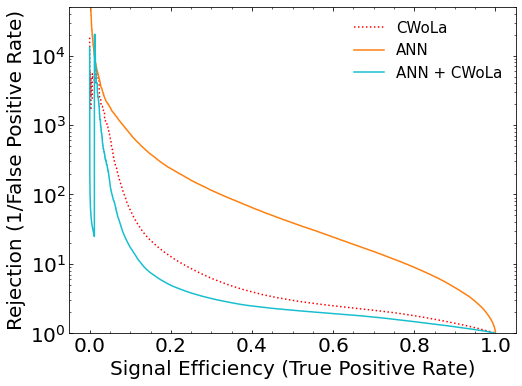

In [58]:
# Plot without banding
mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.yscale("log")
plt.ylim([1,5*1e4])
ERR=False
#plt.plot(tpr_sup,1./fpr_sup,label="Supervised",color='green')

for band in bands:
    if band in ['old-sacwola', 'hl-sacwola']:
        continue
    mu,std = bands[band][3:5]

    plt.plot(tpr_pts, mu, **bands[band][-1])
    if ERR:
        plt.fill_between(tpr_pts, mu - std, mu + std, alpha=.2, color=bands[band][-1]['color'])
#plt.plot(tpr_sup,1./tpr_sup,color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=15,loc="upper right")

# plt.title("Correlated LHCO Example\n(Median of {} models)".format(n_injections),fontsize=20,)
#plt.savefig('C:/Users/knukl/Desktop/FINAL/plots/combined_corr_deltamj_extracorr.pdf', pdf=True, bbox_inches='tight')
#plt.savefig('C:/Users/knukl/Desktop/FINAL/plots/combined_corr_deltamj_extracorr.png', pdf=False, bbox_inches='tight')
# plt.show()

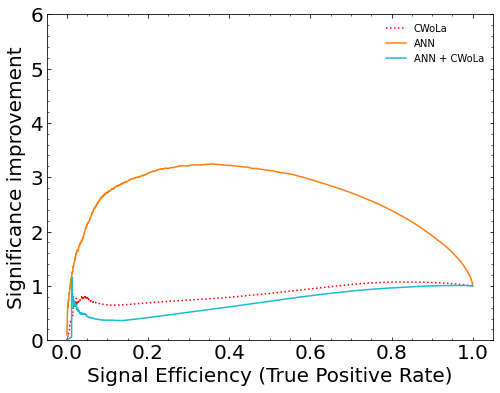

In [59]:
# Plot without banding
mylambda=.5
myklambda = 1 #np.round(len(SR_background_data)/len(SR_background_sim), 3)

ERR = False

fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1])
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([0, 6])



for band in bands:
    if band in ['old-sacwola', 'hl-sacwola']:
        continue
    mu,std = bands[band][5:7]
    plt.plot(tpr_pts, tpr_pts*mu, **bands[band][-1])
#plt.plot(tpr_sup,tpr_sup/np.sqrt(tpr_sup),color="black",ls=":",label="Random")

plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Significance improvement",fontsize=20)
plt.legend(frameon=False,fontsize=10,loc="upper right")
#plt.title(r'$LHC$ $Olympics$ $Example$', loc='right', fontsize=20)

#plt.savefig('C:/Users/knukl/Desktop/FINAL/plots/combined_relsigs_corr_deltamj_extracorr.pdf', pdf=True, bbox_inches='tight')
#plt.savefig('C:/Users/knukl/Desktop/FINAL/plots/combined_relsigs_corr_deltamj_extracorr.png', pdf=False, bbox_inches='tight')